#**Temporal Difference Learning - Deforestation**



In this notebook we will solve a simple deforestation model in the view of a firm which wants to maximize its profits.


![Photo by Pok Rie from Pexels](https://drive.google.com/uc?id=1ZyDlOuX3dxp6QoWJUbUH0HULPG8qIpRd) (Photo by Pok Rie - Pexels)

A firm owns woodland with 100 units of wood. 
The firm must decide how much wood to deforest each year. 
The firm can sell the wood at price $p$ per unit. 
The total cost of extracting $a$ units of wood in any year, given that the area contains $s$ units of wood at the beginning of the year is $c(s, a)$.

The market price $p = 1$, cost of extraction is $c(s, a) = x^2/(1+s)$, and annual discount factor $\gamma = 0.9$.





# **Model**


The units of wood $s$ is a discrete state variable:
- $s \in \{0, 1, 2, \dots, 100\}$


The action variable $a$ is the amount of deforested wood:
- $a \in \{0, 1, 2, \dots, 24\}$

The state transition function is:
- $t(s, a) = s - a$

The reward function is:
- $r(s, a) = p\cdot a - c(s, a)$

# Environment

We are using Open AI Gym to create our environments. 

The Gym interface of an environment is described in
[https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).

Next you will implement the deforestation model with the Open AI Gym framework,
but first import all the necessary libraries for this notebook.

In [1]:
import gym
from gym import spaces

import numpy as np
from numpy.random import default_rng

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

The structure of the gym environment is given. You have to implement the
state transistion only.

In [2]:
class DeforestationEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(DeforestationEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        n_actions = 25
        self.action_space = spaces.Discrete(n_actions)

        # With spaces.Tuple you can create a multidimensional state
        # In our simple model observation and state are synonyms
        self.initial_wood = 100
        self.observation_space = spaces.Discrete(self.initial_wood+1)

        self.price = 1
        
        self.rng = default_rng()
        
        
    def step(self, action):
        """
        State transition of the model.

        """
        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        assert action <= self.state, "%r is to much extraction, current state: %r" % (action, self.state)


        reward = self.profit(self.state, action)

        self.state -= action


        # This is a continuing task, so done is false
        done = self.state == 0

        info = {}

        return self.state, reward, done, info


    def profit(self, state, action):
        return self.price*action - action**2/(1+state)
        

    def reset(self):
        self.state = self.initial_wood
                      
        return self.state

    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass

# **Sarsa Agent**

In [9]:
class SarsaAgent:
    def __init__(self, agent_info):
        """Initialize Agent.

        Args:
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        self.rng = default_rng()

        # Create a dict for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))         


    def step(self, reward, state):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
        
        Returns:
            next_action (int): action the agent takes in next_state
        """

        # choose action using epsilon greedy policy
        action = self.select_action(state)

        # perform update
        target = reward + self.discount * self.q[state][action]
        td_error = target - self.q[self.previous_state][self.previous_action]
        self.q[self.previous_state][self.previous_action] += self.step_size * td_error

        # save current state and action
        self.previous_state = state
        self.previous_action = action

        return action

        
    def select_action(self, state):
        """Select action using epsilon greedy policy

        Args:
            state (int): current state

        Returns:
            action (int): action the agent takes
        """
        
        max_possible_action = np.minimum(state, self.n_actions-1)

        current_q  = self.q[state][:max_possible_action+1]
        if self.rng.random() < self.epsilon:
            action = self.rng.integers(max_possible_action, endpoint=True)
        else:
            action = self.argmax(current_q)

        return action
        
 
    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def start(self, state):
        """Selects action in inital state

        Args:
            state (int): initial state
        
        Returns:
            action (int): initial action
        """

        action = self.select_action(state)

        self.previous_state = state
        self.previous_action = action

        return action




---


**Let's test our environment**


---


You can find the basic structure to simulate the environment in the
[Open AI documentation](https://gym.openai.com/docs/).


In [10]:
env = DeforestationEnv()

n_actions = env.action_space.n
epsilon = 0.1
step_size = 0.8
discount = 0.9


agent_info = {"n_actions": n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = SarsaAgent(agent_info)


n_episodes = 50000

for i in range(n_episodes):
    state = env.reset()
    action = agent.start(state)

    done = False
    while not done:
        state, reward, done, _ = env.step(action)
        action = agent.step(reward, state)


# Perform path simulation
state = env.reset()
action = agent.start(state)

state_path = [state]
action_path = [action]

done = False
while not done:
    state, reward, done, _ = env.step(action)
    action = agent.step(reward, state)

    state_path.append(state)
    action_path.append(action)


---

**Plot the episode**


---


In [11]:
# extract the value function from action value function
V = defaultdict(float)
for state, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state] = value


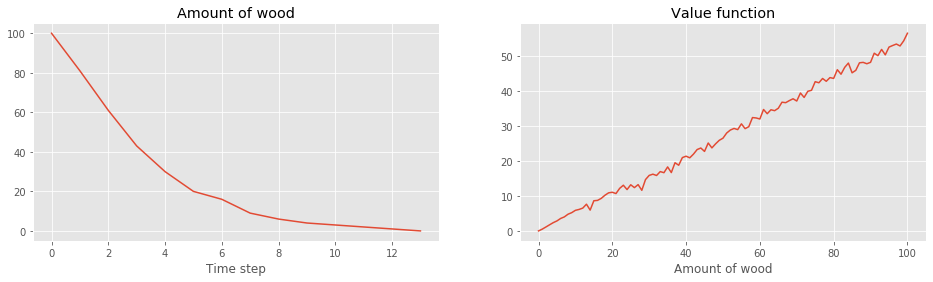

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(state_path)
ax[0].set_title('Amount of wood')
ax[0].set_xlabel('Time step')

ax[1].plot(list(V.keys()), list(V.values()))
ax[1].set_title('Value function')
ax[1].set_xlabel('Amount of wood')

plt.show()

# **Q-Learning Agent**

In [25]:
class QLearningAgent:
    def __init__(self, agent_info):
        """Initialize Agent.

        Args:
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        self.rng = default_rng()

        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))      

    def step(self, reward, state):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
        
        Returns:
            next_action (int): action the agent takes in next_state
        """

        # choose action using epsilon greedy policy
        action = self.select_action(state)

        # perform update
        target = reward + self.discount * np.max(self.q[state])
        td_error = target - self.q[self.previous_state][self.previous_action]
        self.q[self.previous_state][self.previous_action] += self.step_size * td_error

        # save current state and action
        self.previous_state = state
        self.previous_action = action

        return action

        
    def select_action(self, state):
        """Select action using epsilon greedy policy

        Args:
            state (int): current state

        Returns:
            action (int): action the agent takes
        """

        n_possible_actions = np.minimum(state+1, self.n_actions)

        current_q  = self.q[state][:n_possible_actions]
        if self.rng.random() < self.epsilon:
            action = self.rng.integers(n_possible_actions)
        else:
            action = self.argmax(current_q)

        return action


    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def start(self, state):
        """Selects action in inital state

        Args:
            state (int): initial state
        
        Returns:
            action (int): initial action
        """

        action = self.select_action(state)

        self.previous_state = state
        self.previous_action = action

        return action


In [26]:
env = DeforestationEnv()

n_actions = env.action_space.n
n_states = env.observation_space.n
epsilon = 0.6
step_size = 0.8
discount = 0.9


agent_info = {"n_actions": n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = QLearningAgent(agent_info)


n_episodes = 15000

for i in range(n_episodes):
    state = env.reset()
    action = agent.start(state)

    done = False
    while not done:
        state, reward, done, _ = env.step(action)
        action = agent.step(reward, state)


In [27]:
# Perform path simulation
state = env.reset()

agent.epsilon = 0
action = agent.start(state)


state_path = [state]
action_path = [action]

done = False
while not done:
    state, reward, done, _ = env.step(action)
    action = agent.step(reward, state)

    state_path.append(state)
    action_path.append(action)

In [28]:
# extract the value and policy function from action value function
V = defaultdict(float)
policy = defaultdict(int)
for state, values in sorted(agent.q.items()):
    value = np.max(values)
    action = np.argmax(values)
    V[state] = value
    policy[state] = action


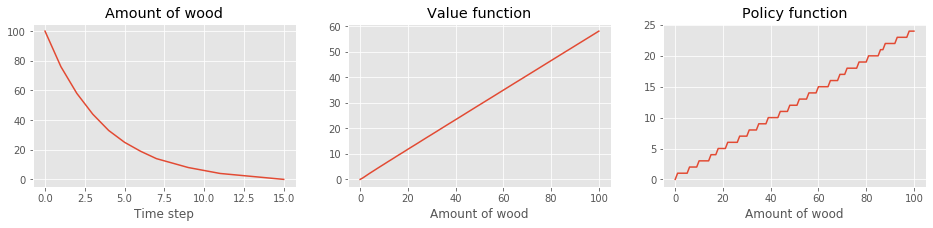

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].plot(state_path)
ax[0].set_title('Amount of wood')
ax[0].set_xlabel('Time step')

ax[1].plot(list(V.keys()), list(V.values()))
ax[1].set_title('Value function')
ax[1].set_xlabel('Amount of wood')

ax[2].plot(list(policy.keys()), list(policy.values()))
ax[2].set_title('Policy function')
ax[2].set_xlabel('Amount of wood')

plt.show()

# **Expected Sarsa**

In [32]:
class ExpectedSarsaAgent:
    def __init__(self, agent_info):
        """Initialize Agent.

        Args:
            agent_info (dict): Parameters used to initialize agent.
            {
                n_actions (int): Number of actions.
                epsilon (float): Exploration parameter.
                step_size (float): Learning rate alpha.
                discount (float): Discount factor gamma.
            }
        """

        self.n_actions = agent_info["n_actions"]
        self.epsilon = agent_info["epsilon"]
        self.step_size = agent_info["step_size"]
        self.discount = agent_info["discount"]

        self.rng = default_rng()

        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.n_actions))        


    def step(self, reward, state):
        """A step taken by the agent

        Args:
            next_state (int):  next state from the environment
        
        Returns:
            next_action (int): action the agent takes in next_state
        """

         # choose action using epsilon greedy policy
        action = self.select_action(state)

        # perform update
        n_possible_actions = np.minimum(state+1, self.n_actions)

        policy = np.ones(n_possible_actions)*self.epsilon/n_possible_actions
        policy[np.argmax(self.q[state])] += 1 - self.epsilon

        expectation = self.q[state][:n_possible_actions] @ policy


        target = reward + self.discount * expectation
        td_error = target - self.q[self.previous_state][self.previous_action]
        self.q[self.previous_state][self.previous_action] += self.step_size * td_error



        # save current state and action
        self.previous_state = state
        self.previous_action = action

        return action

        
    def select_action(self, state):
        """Select action using epsilon greedy policy

        Args:
            state (int): current state

        Returns:
            action (int): action the agent takes
        """

        n_possible_actions = np.minimum(state+1, self.n_actions)

        current_q  = self.q[state][:n_possible_actions]
        if self.rng.random() < self.epsilon:
            action = self.rng.integers(n_possible_actions)
        else:
            action = self.argmax(current_q)

        return action
        

    def argmax(self, q_values):
        """Return the index of maximum value with ties broken randomly.

        Args:
            q_values (numpy.ndarray): A shape-(n_actions,) array of estimated
                action_values.

        Returns:
            index (int): Index of the maximal value.
        """

        ties = np.flatnonzero(np.isclose(q_values, max(q_values)))
        index = self.rng.choice(ties)

        return index


    def start(self, state):
        """Selects action in inital state

        Args:
            state (int): initial state
        
        Returns:
            action (int): initial action
        """

        action = self.select_action(state)

        self.previous_state = state
        self.previous_action = action

        return action

In [37]:
env = DeforestationEnv()

num_actions = env.action_space.n
num_states = env.observation_space.n
epsilon = 0.1
step_size = 0.8
discount = 0.9


agent_info = {"n_actions": n_actions,
              "epsilon": epsilon,
              "step_size": step_size,
              "discount": discount}


agent = ExpectedSarsaAgent(agent_info)


n_episodes = 50000

for _ in range(n_episodes):
    state = env.reset()
    action = agent.start(state)

    done = False
    while not done:
        state, reward, done, _ = env.step(action)
        action = agent.step(reward, state)

In [38]:
# Perform path simulation
state = env.reset()
action = agent.start(state)

state_path = [state]
action_path = [action]

done = False
while not done:
    state, reward, done, _ = env.step(action)
    action = agent.step(reward, state)

    state_path.append(state)
    action_path.append(action)

In [39]:
# extract the value and policy function from action value function
V = defaultdict(float)
for state, values in sorted(agent.q.items()):
    value = np.max(values)
    V[state] = value
    

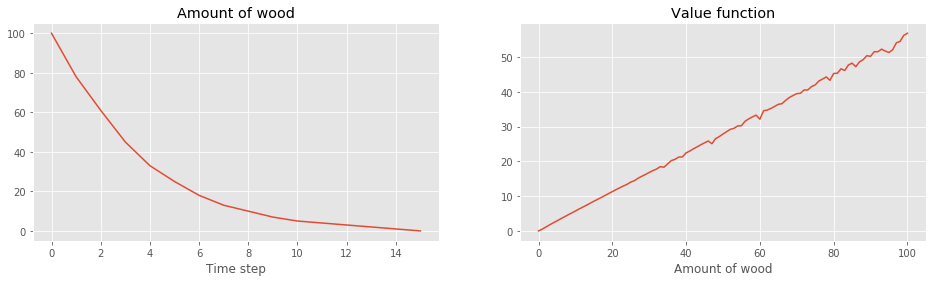

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(state_path)
ax[0].set_title('Amount of wood')
ax[0].set_xlabel('Time step')

ax[1].plot(list(V.keys()), list(V.values()))
ax[1].set_title('Value function')
ax[1].set_xlabel('Amount of wood')


plt.show()